# Case Study: Artisanal Mining Sites in Congo

In this notebook, a case study is analyzed: artisanal mining sites in Congo. The data set is from [IPIS: International Peace Service](https://ipisresearch.be). It contains information about the mines: location, minerals being mined, social insecurity situation. More information: [IPIS Open Data Tutorial](https://ipisresearch.be/wp-content/uploads/2018/03/Open_Data_Tutorial.html).

Links to explore the dataset source repositories:

- [IPIS Open Data](https://ipisresearch.be/home/maps-data/open-data/)
- [World Resources Institute](https://www.wri.org/)

Look at the companion guide: [`README.md`](../README.md).

Table of contents:


## 4. Case Study: Artisanal Mining Sites

### 4.1 File Formats

There are many file formats supported by Geopandas, with pros/cons:

- ESRI Shapefiles: most extended, but distributed in several files, all necessary: `.shp`, `.dbf`, `shx`, `.prj`.
- `GeoJSON`: lightweight, often used in web applications. 
- GeoPackage: `.gpkg`, new, with more capabilities
- ...
- Geopandas can also read from geo-databases, like [PostGIS](https://postgis.net/), a spatial databse extender for PostgreSQL.

Geopandas can read and write those files: `.to_file()`:

```python
# Writing a Shapefile file
geodataframe.to_file("mydata.shp", driver='ESRI Shapefile')

# Writing a GeoJSON file
geodataframe.to_file("mydata.geojson", driver='GeoJSON')

# Writing a GeoPackage file
geodataframe.to_file("mydata.gpkg", driver='GPKG')
```

### 4.2 Explore the Dataset

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [4]:
DATA_PATH = "../../data/work_geodata/Mines/"

In [5]:
# Read the mining site data
mining_sites = gpd.read_file(DATA_PATH+"ipis_cod_mines.geojson")

In [6]:
# Print the first rows and the CRS information
mining_sites.head()

,visit_date,name,n_workers,mineral,geometry
0,2013-03-27,Mayi-Tatu,150.0,Gold,POINT (29.66033 1.01089)
1,2013-03-27,Mabanga,115.0,Gold,POINT (29.65862 1.00308)
2,2013-03-27,Molende,130.0,Gold,POINT (29.65629 0.98563)
3,2013-03-27,Embouchure,135.0,Gold,POINT (29.64494 0.99976)
4,2013-03-27,Apumu-Atandele-Jerusalem-Luka Yayo,270.0,Gold,POINT (29.66000 0.95600)


In [7]:
mining_sites.shape

(2143, 5)

In [8]:
print(mining_sites.crs)

epsg:4326


<AxesSubplot:>

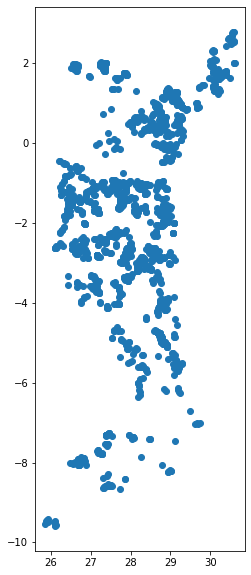

In [9]:
# Make a quick visualisation
mining_sites.plot(figsize=(10,10))

In [10]:
# Read the Congo protected areas data
protected_areas = gpd.read_file(DATA_PATH+"wdpamay2017cod-shapefile-polygons.geojson")

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


<AxesSubplot:>

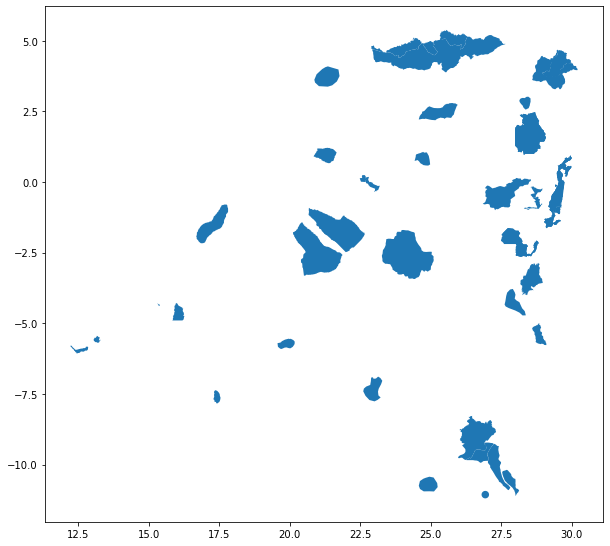

In [11]:
# Make a quick visualisation
protected_areas.plot(figsize=(10,10))

In [12]:
# Convert both datasets to UTM projection
mining_sites_utm = mining_sites.to_crs(epsg=32735)
protected_areas_utm = protected_areas.to_crs(epsg=32735)

/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


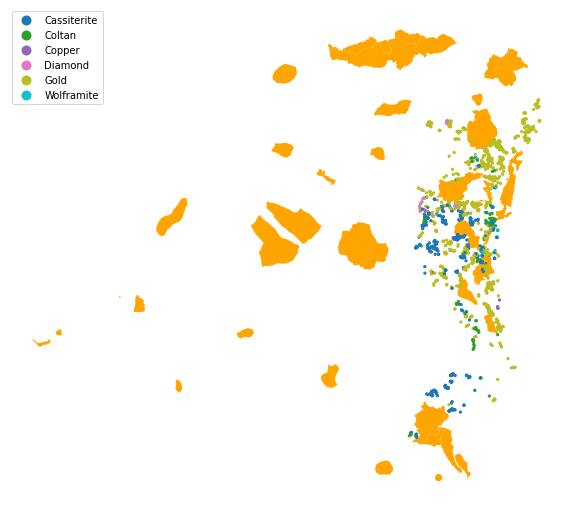

In [13]:
# Visualize both datasets
ax = protected_areas_utm.plot(color='orange',
                              figsize=(10,10))
mining_sites_utm.plot(ax=ax,
                      markersize=5,
                      column='mineral',
                      #alpha=0.5,
                      legend=True,
                      legend_kwds={'loc':'upper left'})
ax.set_axis_off()
plt.show()

In [14]:
# Write converted data to a file
# Warning: With SHP, several files created - all necessary!
mining_sites_utm.to_file(DATA_PATH+"ipis_cod_mines_utm.gpkg", driver='GPKG')
protected_areas_utm.to_file(DATA_PATH+"cod_conservation_utm.shp", driver='ESRI Shapefile')

### 4.3 Additional Spatial Operations: Unary Union and Buffer

We have seen many spatial operations:

- Boolean spatial relationships: `intersects`, etc. 
- Geometry operations: `intersection`, etc.
- Spatial joins.
- Combined geometries with overlay.

There are other common spatial operations:

- **Unary union**: given a `GeoSeries`, i.e., a colum/series of `geometry` objects, create a geometry that unites and contains all of them. Example: given all countries in a continent, create the polygon of the continent.
- **Buffer**: given a geometry, create an *inflated* geometry which contains it witha a safety/distance margin. Example: create a 2km distance area around a river (a line).

#### Example 1: National Park Area and Mines in 50 km around City of Goma

In [15]:
from shapely.geometry import Point
import geopandas as gpd

In [16]:
goma = Point(746989.5594829298, 9816380.942287602)

In [17]:
# goma is a Point: 746989.5594829298 9816380.942287602
print(type(goma))

# Create a buffer of 50km around Goma
goma_buffer = goma.buffer(50000)

# The buffer is a polygon
print(type(goma_buffer))

# Area of circle centered in Goma: pi*R^2
print(goma_buffer.area / (1000**2))

# Check how many sites are located within the buffer
mask = mining_sites_utm.within(goma_buffer)
print(mask.sum())

# Calculate the area of national park within the buffer
print(protected_areas_utm.intersection(goma_buffer).geometry.area.sum() / (1000**2))

<class 'shapely.geometry.point.Point'>
<class 'shapely.geometry.polygon.Polygon'>
7841.371226364861
87
3894.8385678792906


#### Example 2: Mining Sites in National Parks

In [18]:
protected_areas_utm.head()

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,geometry
0,555555524.0,555555524,1,Lyondji Bonobo Community Reserve,Réserve Communautaires des Bonobos d' Iyondji,Forêt Classée et Réserve Communautaire,Classified Forest and Community Reserve,National,Not Reported,Not Applicable,...,Collaborative governance,Not Reported,l'Institut CongolaispourConservation dela Natu...,Not Reported,Not Reported,1717,Not Reported,COD,COD,"MULTIPOLYGON (((30396.594 10020600.079, 30542...."
1,478291.0,478291,1,Parc national des Virunga,Parc national des Virunga,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,Not Reported,...,Not Reported,Not Reported,Not Reported,Management plan is not implented but is available,State Verified,1856,Not Reported,COD,COD,"MULTIPOLYGON (((735540.644 9817696.449, 735598..."
2,72340.0,72340,1,Luo Scientific Reserve,Réserve Scientifique de la Luo,Réserve,Scientific Reserve,National,Not Reported,Not Applicable,...,Government-delegated management,Not Reported,Center for Research in Natural Sciences (CRSN/...,Not Reported,Not Reported,1717,Not Reported,COD,COD,"MULTIPOLYGON (((6196.581 10027613.404, 6856.29..."
3,478292.0,478292,1,Salonga,Parc National de la Salonga,Réserve Naturelle Integrale,Integrale Nature Reserve,National,II,Not Applicable,...,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,1717,Not Reported,COD,COD,"MULTIPOLYGON (((-227210.952 9829733.977, -2271..."
4,9143.0,9143,1,Réserve forestière de Luki,Réserve forestière de Luki,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,715,CD-KW,COD,COD,"MULTIPOLYGON (((-1038605.456 9373038.040, -103..."


In [19]:
protected_areas_utm.columns

Index(['WDPAID', 'WDPA_PID', 'PA_DEF', 'NAME', 'ORIG_NAME', 'DESIG',
       'DESIG_ENG', 'DESIG_TYPE', 'IUCN_CAT', 'INT_CRIT', 'MARINE',
       'REP_M_AREA', 'GIS_M_AREA', 'REP_AREA', 'GIS_AREA', 'NO_TAKE',
       'NO_TK_AREA', 'STATUS', 'STATUS_YR', 'GOV_TYPE', 'OWN_TYPE',
       'MANG_AUTH', 'MANG_PLAN', 'VERIF', 'METADATAID', 'SUB_LOC',
       'PARENT_ISO', 'ISO3', 'geometry'],
      dtype='object')

In [20]:
# Extract the single polygon for the Kahuzi-Biega National park
kahuzi = protected_areas_utm[protected_areas_utm['NAME'] == "Kahuzi-Biega National park"].geometry.squeeze()

# Take a subset of the mining sites located within Kahuzi
sites_kahuzi = mining_sites_utm[mining_sites_utm.within(kahuzi)]
print(sites_kahuzi)

# Determine in which national park a mining site is located
sites_within_park = gpd.sjoin(mining_sites_utm,
                              protected_areas_utm,
                              op='within',
                              how='inner')

Empty GeoDataFrame
Columns: [visit_date, name, n_workers, mineral, geometry]
Index: []


/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/geopandas/base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
/Users/mxagar/opt/anaconda3/envs/ds/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [21]:
sites_within_park.head()

,visit_date,name,n_workers,mineral,geometry,index_right,WDPAID,WDPA_PID,PA_DEF,NAME,...,STATUS_YR,GOV_TYPE,OWN_TYPE,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3
253,2013-09-05,Kiviri/Tayna,244.0,Gold,POINT (709734.913 9961013.720),23,317056.0,317056,1,Tayna,...,0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,825,Not Reported,COD,COD
578,2015-09-02,Lubondozi 3,30.0,Gold,POINT (578464.315 9555456.293),29,555512066.0,555512066,1,Luama-Kivu,...,0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,825,Not Reported,COD,COD
579,2015-09-02,Katamu,180.0,Gold,POINT (576249.903 9554313.725),29,555512066.0,555512066,1,Luama-Kivu,...,0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,825,Not Reported,COD,COD
580,2015-09-02,Kimabwe 1,120.0,Gold,POINT (576425.777 9556329.634),29,555512066.0,555512066,1,Luama-Kivu,...,0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,825,Not Reported,COD,COD
581,2015-09-02,Lubondozi 1,300.0,Gold,POINT (579164.711 9554722.924),29,555512066.0,555512066,1,Luama-Kivu,...,0,Not Reported,Not Reported,Not Reported,Not Reported,Not Reported,825,Not Reported,COD,COD


In [22]:
sites_within_park.shape

(68, 34)

In [23]:
# The number of mining sites in each national park
sites_within_park['NAME'].value_counts()

Itombwe                       21
Kahuzi-Biega                  11
Kahuzi-Biega National Park    10
Luama-Kivu                     9
Okapi                          5
Okapi Wildlife Reserve         5
Luama-Katanga                  3
Maiko                          3
Tayna                          1
Name: NAME, dtype: int64

### 4.4 Custom Spatial Operations

We can use the available geometry operations to build custom functions that are applied to a `GeoSeries` using `GeoSeries.apply(function, **kwargs)`.

For instance, image we want to measure the river length in an area of 50 km radius of the cities contained in a dataset:

```python
# Define the specific operation function
def river_length(geom, rivers):
    area = geom.buffer(50000)
    rivers_within_area = rivers.intersection(area)
    return rivers_within_area.length.sum() / 1000

# The function works with a single geometry
river_length(cairo, rivers=rivers) # 186.39

# And it works with a GeoDataFrame geometry column or a GeoSeries
# We can store the result as a column
cities['river_length'] = cities.geometry.apply(river_length, rivers=rivers)
```

#### Example 1: Distance from Parks to Mines

In [24]:
# Get the geometry of the first row
single_mine = mining_sites_utm.geometry[0]

# Calculate the distance from each national park to this mine
dist = protected_areas_utm.distance(single_mine)

# The index of the minimal distance
idx = dist.idxmin()

# Access the name of the corresponding national park
closest_park = protected_areas_utm.loc[idx, 'NAME']
print(closest_park)

Virunga


#### Example 2: Closest National Park from Each Mine

In [25]:
# Define a function that returns the closest national park
def closest_national_park(geom, national_parks):
    dist = national_parks.distance(geom)
    idx = dist.idxmin()
    closest_park = national_parks.loc[idx, 'NAME']
    return closest_park

In [26]:
# Call the function on single_mine
print(closest_national_park(single_mine, protected_areas_utm))

Virunga


In [27]:
# Apply the function to all mining sites
mining_sites['closest_park'] = mining_sites.geometry.apply(closest_national_park, national_parks=protected_areas_utm)
mining_sites.head()

,visit_date,name,n_workers,mineral,geometry,closest_park
0,2013-03-27,Mayi-Tatu,150.0,Gold,POINT (29.66033 1.01089),Lufira
1,2013-03-27,Mabanga,115.0,Gold,POINT (29.65862 1.00308),Lufira
2,2013-03-27,Molende,130.0,Gold,POINT (29.65629 0.98563),Lufira
3,2013-03-27,Embouchure,135.0,Gold,POINT (29.64494 0.99976),Lufira
4,2013-03-27,Apumu-Atandele-Jerusalem-Luka Yayo,270.0,Gold,POINT (29.66000 0.95600),Lufira


### 4.5 Working with Raster Data

Rasterized data are pixel grids which can have several channels or **bands** with discrete or continuous values in them. Examples:

- Satellite images (3 bands, continuous)
- Rain probability map (1 band, continuous)
- Elevation map (1 band, continuous)
- Land usage raster map (1 band, discrete)

The [GDAL](https://gdal.org/index.html) library contains state-of-the-art methods to deal with raster data. A pythonic binding to use GDAL is [RasterIO](https://rasterio.readthedocs.io/en/stable/intro.html). In this section, we'll use `rasterio` along with [`rasterstats`](https://pythonhosted.org/rasterstats/), which allows combining raster datasets with vector geometries.

Links:

- [RasterIO](https://rasterio.readthedocs.io/en/stable/intro.html)
- [GDAL: Geospatial Data Abstraction Library](https://gdal.org/index.html)
- [The Open Source Geospatial Foundation: OSGeo](https://www.osgeo.org/)
- [rasterstats](https://pythonhosted.org/rasterstats/)

Installation:

```bash
brew install gdal
python -m pip install rasterio
python -m pip install rasterstats
```

#### Example 1: Visualize Raster Images + Vector Geometries

In [28]:
import rasterio
import rasterio.plot
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

In [29]:
DATA_PATH = "../../data/work_geodata/Madagascar_27_01_2020/"

In [30]:
# Open the raster dataset
# HOWEVER, only the metadata is loaded
# and we can access all the metadata attributes with .
src = rasterio.open(DATA_PATH+"2020-01-27-00_00_2020-01-27-23_59_Landsat_8_(USGS_archive)_B01_(Raw).tiff")

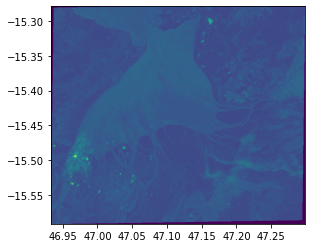

In [31]:
# Visualize
ax = rasterio.plot.show(src)

In [32]:
print(src.crs)

EPSG:4326


In [33]:
src.count # number of bands

1

In [34]:
src.width, src.height

(676, 602)

In [35]:
# Get numpy array of raster image
array = src.read()

In [36]:
array

array([[[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ..., 6960, 6698, 6639],
        ...,
        [8087, 8087, 8860, ...,    0,    0,    0],
        [8113, 8244, 8349, ...,    0,    0,    0],
        [7563, 8166, 8251, ...,    0,    0,    0]]], dtype=uint16)

In [37]:
array.shape

(1, 602, 676)

In [38]:
src.bounds # bbox

BoundingBox(left=46.933594, bottom=-15.591767, right=47.298203, top=-15.278872)

In [39]:
src.offsets

(0.0,)

In [40]:
src.res # resolution?

(0.0005393624260355052, 0.0005197591362126263)

In [41]:
src.transform

Affine(0.0005393624260355052, 0.0, 46.933594,
       0.0, -0.0005197591362126263, -15.278872)

In [42]:
from shapely import Polygon
from shapely.geometry import box

# Create a GeoSeries of points located on the raster image region
pt1 = Point(47.05, -15.40)
pt2 = Point(47.15, -15.45)
pt3 = Point(47.25, -15.30)
# For more information on how to create Shapely objects
# https://shapely.readthedocs.io/en/stable/manual.html
rectangle = box(minx=46.95, miny=-15.58, maxx=47.28, maxy=-15.28, ccw=True)

#shapes = gpd.GeoSeries([pt1, pt2, pt3, rectangle], crs = {'init':  'epsg:4326'})
#shapes = gpd.GeoSeries([pt1, pt2, pt3], crs = {'init':  'epsg:4326'})
shapes = gpd.GeoSeries([pt1, pt2, pt3], crs = 'epsg:4326')

In [43]:
shapes

0    POINT (47.05000 -15.40000)
1    POINT (47.15000 -15.45000)
2    POINT (47.25000 -15.30000)
dtype: geometry

In [44]:
shapes.to_crs(epsg = 4326)

0    POINT (47.05000 -15.40000)
1    POINT (47.15000 -15.45000)
2    POINT (47.25000 -15.30000)
dtype: geometry

In [45]:
print(shapes.crs)

epsg:4326


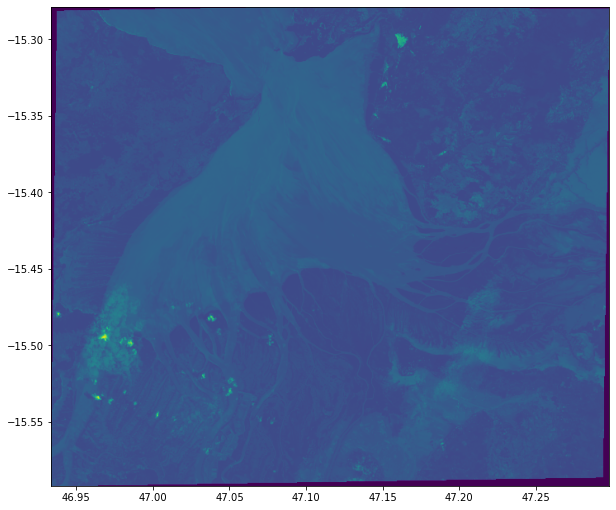

<Figure size 432x288 with 0 Axes>

In [46]:
# Plot both: raster image + vector geometries
# WARNING: Even though both are in the same CRS and have overlapping coordinates
# they're not plotted together...
plt.figure(figsize=(10,10))
ax = rasterio.plot.show(src)
shapes.plot(ax=ax, markersize=20, color='red')
#shapes.plot(markersize=10, color='red')
plt.show()

#### Example 2: Extract Information from Raster

This example broke the kernel, so I'm just writing the snippets from the slides:

**Extract raster values with rasterstats:**

*From points:*

```python
import rasterstats

rasterstats.point_query(geometries, "path/to/raster",
                        interpolation='nearest'|'bilinear')
```

*From polygons:*

```python
import rasterstats
rasterstats.zonal_stats(geometries, "path/to/raster",
                        stats=['min', 'mean', 'max'])
```

*Example:*

```python
import rasterstats

result = rasterstats.zonal_stats(countries.geometry, "DEM_gworld.tif",
                                 stats=['mean'])
countries['mean_elevation'] = pd.DataFrame(result)
countries.sort_values('mean_elevation', ascending=False).head()
```